Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import dask.dataframe as dd
import dask.dataframe as dd
import os
import json
from dask_ml.preprocessing import StandardScaler
from dask_ml.linear_model import LinearRegression
from dask.distributed import LocalCluster, Client
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
import time
import pandas as pd
import matplotlib.pyplot as plt
from dask.distributed import LocalCluster, Client
from memory_profiler import memory_usage
from sklearn.linear_model import SGDRegressor


In [2]:
os.chdir('C:\\Users\\Uporabnik\\Documents\\FRI\\BD_project')


### Set up

In [ ]:
# Cluster configuration
n_workers = 3
memory_limit = '9GB'
file_type = 'parquet'

print(memory_limit)
#memory_limit = '8GB'
cluster = LocalCluster(n_workers=n_workers, memory_limit=memory_limit)

client = Client(cluster)
print(client)


9GB
<Client: 'tcp://127.0.0.1:54746' processes=3 threads=18, memory=25.15 GiB>


In [4]:
time_dict = {
    "n_workers": n_workers,
    "memory_limit": memory_limit,
    "file_type": file_type
}

In [5]:
# get to c:\Users\Uporabnik\Documents\FRI\BD_project\data\parquet_files

#DATA_DIR = '/d/hpc/projects/FRI/bigdata/students/mk75264/data/augmented'  # Update this path accordingly
DATA_DIR = 'C:/Users/Uporabnik/Documents/FRI/BD_project/data/parquet_files'

In [19]:
# read in the parquet files but only the first 10 partitions
def read_parquet_files():
    start = time.time()
    df = dd.read_parquet(DATA_DIR + '/*.parquet', engine='pyarrow', )
    end = time.time()
    print("Time to read parquet files: ", end-start)

    time_dict['read'] = end - start
    return df

mem_usage = memory_usage(read_parquet_files, max_usage=True)
df = read_parquet_files()

print(f"Peak memory usage: {mem_usage} MB")


Time to read parquet files:  0.2325890064239502
Time to read parquet files:  0.07518887519836426
Peak memory usage: 343.44921875 MB


In [20]:
# Code does not work without repartitioning
df = df.repartition(npartitions=10)

In [21]:
df.dtypes

Summons Number                       string[pyarrow]
Plate ID                             string[pyarrow]
Registration State                   string[pyarrow]
Plate Type                           string[pyarrow]
Issue Date                           string[pyarrow]
Violation Code                       string[pyarrow]
Vehicle Body Type                    string[pyarrow]
Vehicle Make                         string[pyarrow]
Issuing Agency                       string[pyarrow]
Street Code1                         string[pyarrow]
Street Code2                         string[pyarrow]
Street Code3                         string[pyarrow]
Vehicle Expiration Date              string[pyarrow]
Violation Location                   string[pyarrow]
Violation Precinct                   string[pyarrow]
Issuer Precinct                      string[pyarrow]
Issuer Code                          string[pyarrow]
Issuer Command                       string[pyarrow]
Issuer Squad                         string[py

### Data preparation

In [25]:
# Columns to keep
columns_to_keep = [
    'Issue Date', 
    #'Plate ID', 
    #'Violation Code', 
    #'Registration State', #- for plotting
    #'Plate Type', 
    #'Vehicle Body Type', 
    #'Vehicle Color', 
    'Vehicle Make', 
    #'Issuing Agency', 
    #'Violation Time', #!! change
    #'Vehicle Year', 
    #'Time First Observed', 
    #'Violation County', # we have alread
    #'Street'
    #'n_tickets',
    'Schools',
    'Businesses',
    'Attractions',
    'AWND',
    'PRCP',
    'SNOW',
    'TMAX',
    'TMIN',
    'borough_normalized_events',
    'day_normalized_events',
    ]

In [26]:
df = df[columns_to_keep]
df = df.dropna()
df.head()

,Issue Date,Vehicle Make,Schools,Businesses,Attractions,AWND,PRCP,SNOW,TMAX,TMIN,borough_normalized_events,day_normalized_events
7,2013-07-01,CHEVR,0.19953188999414861,0.16281053114106314,0.08143322475570032,3.13,0.84,0.0,77,72,0.0003740065451145,0.1666666666666666
22,2013-07-01,SAAB,0.042715038033937974,0.03292314143269856,0.05211726384364821,3.13,0.84,0.0,77,72,0.0001134816159782,0.0416666666666666
33,2013-07-01,BMW,0.19953188999414861,0.16281053114106314,0.08143322475570032,3.13,0.84,0.0,77,72,0.0003740065451145,0.1666666666666666
53,2013-07-01,DODGE,0.19953188999414861,0.16281053114106314,0.08143322475570032,3.13,0.84,0.0,77,72,0.0003740065451145,0.1666666666666666
115,2013-07-01,FORD,0.19953188999414861,0.16281053114106314,0.08143322475570032,3.13,0.84,0.0,77,72,0.0003740065451145,0.1666666666666666


#TODO: We also have to select the appropriate locations here: so all, county, or most interesting streets.

In [27]:
# keep only the top 10 vehicle makes
top_vehicle_makes = df['Vehicle Make'].value_counts().nlargest(10).index
df = df[df['Vehicle Make'].isin(top_vehicle_makes)]



## Grouping data

In [28]:
df = df.persist()

In [ ]:
df["n_tickets"] = 1

df = df.groupby(['Issue Date', 'Vehicle Make']).agg({
    'n_tickets': 'sum', 
    'Schools': 'mean',
    'Businesses': 'mean',
    'Attractions': 'mean',
    'AWND': 'mean',
    'PRCP': 'mean',
    'SNOW': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean',
    'borough_normalized_events': 'mean',  # if applicable
    'day_normalized_events': 'mean'  # if applicable
}).reset_index()

df_pred = df.compute().reset_index()

In [93]:
df_pred.head()

,Issue Date,Vehicle Make,n_tickets
0,2013-07-01,BMW,2
1,2013-07-01,BUICK,2
2,2013-07-01,CADIL,1
3,2013-07-01,CHEVR,6
4,2013-07-01,CHRYS,3


In [94]:
df_pred.sort_values(by="n_tickets")

,Issue Date,Vehicle Make,n_tickets
546875,2024-06-30,TOYOT,1
333129,2020-01-19,ROLLS,1
142072,2016-01-29,FT,1
142073,2016-01-29,FT/LI,1
333128,2020-01-19,RA/RO,1
...,...,...,...
422597,2021-11-26,HONDA,9317
70920,2015-01-20,FORD,9362
375089,2020-11-27,HONDA,9384
71092,2015-01-22,FORD,9657


22.691249936000116

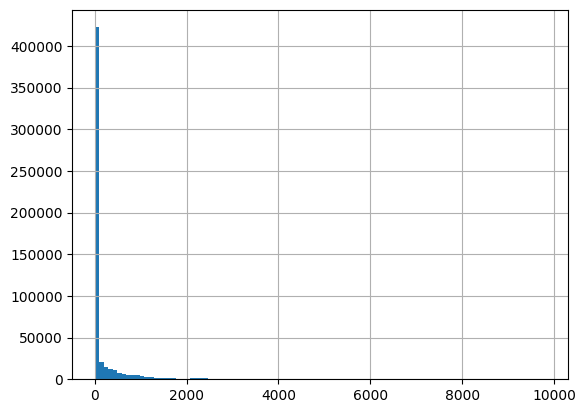

In [33]:
# distribution of number of tickets
df_pred["n_tickets"].hist(bins=100)


# percentage that is more than 100 tickets
(df_pred["n_tickets"] > 100).sum() / len(df_pred) * 100

In [36]:
df = df_pred

In [555]:
#get dummies for the county
df = pd.get_dummies(df, columns=['Vehicle Make']).astype(float)

## SPLIT HERE AND RUN BOTH PARTS ON HPC

## Predictions

In [556]:
X = df
y = X.pop('n_tickets')

In [605]:
# save df and X, y to pickle files
df.to_pickle('data/ml/df_vehicle_make.pkl')
X.to_pickle('data/ml/X_vehicle_make.pkl')
y.to_pickle('data/ml/y_vehicle_make.pkl')

In [609]:
# Choose the start and end date
split_date = '2019-07-01'

X_train, X_test = X.loc[:split_date], X.loc[split_date:]
y_train, y_test = y.loc[:split_date], y.loc[split_date:]

# ADD TIME HERE!!!

In [610]:
# print all nan rows and percentage of nan rows
print(X_train.isnull().sum())
print(X_train.isnull().sum()/len(X_train))
print(y_train.isnull().sum())
print("X_test:")
print(X_test.isnull().sum())
print(X_test.isnull().sum()/len(X_test))
print(y_test.isnull().sum())


Schools                           0
Businesses                        0
Attractions                       0
day                               0
month                             0
year                              0
day_of_week                       0
AWND                         189582
PRCP                           3603
SNOW                          85037
TMAX                         217868
TMIN                         217868
borough_normalized_events    142743
day_normalized_events        142743
Violation County_BX               0
Violation County_K                0
Violation County_NY               0
Violation County_Q                0
Violation County_R                0
dtype: int64
Schools                      0.000000
Businesses                   0.000000
Attractions                  0.000000
day                          0.000000
month                        0.000000
year                         0.000000
day_of_week                  0.000000
AWND                         0.828611

In [611]:
# fill missing values with 0, since there are some especially in the weather data
X_train = X_train.fillna(X_train.mean()) 
X_test = X_test.fillna(X_test.mean())

#X_train = X_train.fillna(0) 
#X_test = X_test.fillna(0)

In [612]:
# save feature names to later plot feature importance
feature_names = [f'{name}' for name in X_train.columns]

In [613]:
# Trasnsorming to dask arrays
X_train = dd.from_pandas(X_train, npartitions=10)
X_test = dd.from_pandas(X_test, npartitions=10)
y_train = dd.from_pandas(y_train, npartitions=10)
y_test = dd.from_pandas(y_test, npartitions=10)

X_train = X_train.to_dask_array()
X_test = X_test.to_dask_array()
y_train = y_train.to_dask_array()
y_test = y_test.compute().values

# Scaling the data
scaler_train = StandardScaler()
scaler_test = StandardScaler()

X_train = scaler_train.fit_transform(X_train)
X_test = scaler_test.fit_transform(X_test)

c:\Users\Uporabnik\.conda\envs\bdproject\Lib\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 34.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [614]:
def plot_predictions(y_test, y_pred, model_name, file_type, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_test, y_pred, color='blue', alpha=0.5) 
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
    ax.set_xlabel("True Values")  
    ax.set_ylabel("Predicted Values")
    ax.set_title(title)  
    ax.grid(True)
    fig.tight_layout()
    plt.savefig(f"plots/results_{model_name}_{file_type}.png")
    plt.show()

### Dask Linear Regression

In [ ]:
def run_lr():    
# LR
    start_time = time.time()

    clf = LinearRegression() #fit_intercept=0
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred = y_pred.compute()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    plot_predictions(
        y_test, y_pred, "LinearRegression", file_type=file_type, title=f"LR RMSE: {rmse:.2f}"
    )

    end_time = time.time()

    print("LR RMSE: ", rmse)
    print(f"Time to fit and predict for Linear Regression: {end_time - start_time:.2f} seconds")

mem_usage = memory_usage(run_lr, max_usage=True)
print(f"Peak memory usage: {mem_usage} MB")
# rmse: 3 9 5271.0
# rmse: 4 6 5244.9
#      5 5 5271.0


### XGBoost:

In [ ]:
def run_xgboost():  
  # XGBoost
    print("XGBoost results:")
    start_time = time.time()

    clf = xgb.XGBRegressor()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    plot_predictions(y_test, y_pred, "XGBoost", file_type=file_type, title=f"XGBoost RMSE: {rmse :.2f}")
    print("RMSE: ", rmse)
    end_time = time.time()
    print(f"Time for fit and predict with XGBoost: {end_time - start_time:.2f} seconds")

mem_usage = memory_usage(run_xgboost, max_usage=True)
print(f"Peak memory usage: {mem_usage} MB")

# rmse: 3 9 5236.7
# rmse: 4 6 5327.62
# rmse: 5 5 (n_partitions=15)

### partial_fit with SGDRegressor

In [ ]:
def SGD_train_and_predict():
    clf = SGDRegressor()  # fit_intercept=0 if needed
    for i in range(10):
        clf.partial_fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    plot_predictions(
        y_test, y_pred, "SGDRegressor", file_type=file_type, title=f"SGD RMSE: {rmse:.2f}"
    )
    return rmse

# Measure time and memory
start_time = time.time()
mem_usage = memory_usage(SGD_train_and_predict, max_usage=True)  # Returns the maximum memory usage
end_time = time.time()

print(f"SGD RMSE: {SGD_train_and_predict():.2f}")
print(f"Time to fit and predict for SGDRegressor: {end_time - start_time:.2f} seconds")
print(f"Peak memory usage: {mem_usage:.2f} MiB")

# rmse: 3 9 4912.4
# rmse: 4 6 4880.54
# rmse: 5 5 4966.0